In [1]:
import numpy as np 
import healpy as hp
import matplotlib.pyplot as plt
import mylib
from tqdm import tqdm
from importlib import reload
import pymaster as nmt
import mylib
import scipy as sp
import camb

In [2]:
def get_camb(Alens, r, lmax):
    pars = camb.read_ini('https://raw.githubusercontent.com/cmbant/CAMB/master/inifiles/planck_2018.ini')
    pars.Alens = Alens
    if r != 0:
        pars.WantTensors=True
        pars.InitPower.set_params(r=r)
    results = camb.get_results(pars)
    return results.get_total_cls(lmax, 'muK', True).T

In [3]:
nside = 128
lmax = 3*nside - 1
npix = 12 * nside**2

input_cls = get_camb(1, 0, lmax)

input_cls_noBB = np.copy(input_cls)
input_cls_noBB[2] = np.zeros(lmax+1)

input_cls_noEE = np.copy(input_cls)
input_cls_noEE[1] = np.zeros(lmax+1)
input_cls_noEE[3] = np.zeros(lmax+1)

4.40673828125


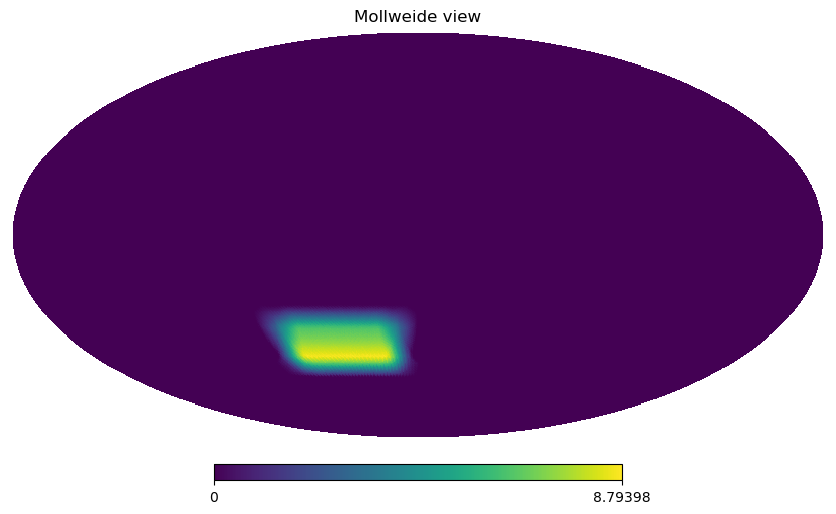

In [13]:
qq, qu, uu = hp.read_map(f'obsmat_nside{nside}/out/0/filterbin_invcov.fits', field=[3,4,5])
mask = np.zeros(npix)
mask[qq!=0] = 1
tr = qq + uu
det = qq * uu - qu * qu
weight = 0.5 * (tr - np.sqrt(tr ** 2 - 4 * det) ) 

mask_apo = nmt.mask_apodization(weight, 2, 'C2') 
mask_apo /= np.sqrt(np.mean(mask_apo**2)) 

hp.mollview(mask_apo)
fsky = len(mask[mask!=0])/npix
print(fsky*100)

w2 = np.sum(mask_apo**2)/np.sum(mask)
w4 = np.sum(mask_apo**4)/np.sum(mask)

R_unapo = sp.sparse.load_npz(f'obsmat_nside{nside}/obsmat.npz')
# R_QU_unapo = R_unapo[npix:, npix:]

Z = sp.sparse.diags_array(mask_apo)
ZZ = sp.sparse.block_diag([Z, Z, Z])

R = ZZ @ R_unapo
# R_QU = R[npix:, npix:]

pi_b = sp.sparse.load_npz(f'pi_b_3000.npz')

In [5]:
bin_size = 16
b = nmt.NmtBin.from_nside_linear(nside, bin_size)
ells = b.get_effective_ells()
c2db = ells * (ells+1) /2/np.pi
l = np.arange(lmax+1)
c2d = l * (l+1) / 2/np.pi
sigmab = hp.nside2resol(nside)
fwhm = (8*np.log(2))**0.5 * sigmab
bl = hp.gauss_beam(fwhm, lmax) 

mll_KS = mylib.get_mll(mask_apo, nside, b)[2::4,2::4]
mll = mylib.get_mll(mask_apo, nside, b, purify_b=False)[2::4,2::4]

In [11]:
#filter transfer
nmc_transfer = 128

pcl = np.zeros(lmax+1)
pcl_pure = np.zeros(lmax+1)

pcl_KS = np.zeros(lmax+1)

for i in tqdm(range(nmc_transfer)):
    np.random.seed(i+1000)
    m = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    obs_m = (R @ m.flatten()).reshape(3, npix)   
    pcl += hp.anafast(obs_m)[2]

    obs_m_unapo = (R_unapo @ m.flatten()).reshape(3, npix)   
    f = nmt.NmtField(mask_apo, obs_m_unapo[1:], purify_b=True)
    pcl_KS += nmt.compute_coupled_cell(f, f)[3]

    obs_m[1:] = (pi_b @ obs_m[1:].flatten()).reshape(2, npix)
    pcl_pure += hp.anafast(obs_m)[2]
    
pcl /= nmc_transfer
pcl_KS /= nmc_transfer
pcl_pure /= nmc_transfer

100%|█████████████████████████████████████████████████████████████████| 128/128 [04:47<00:00,  2.24s/it]


[]

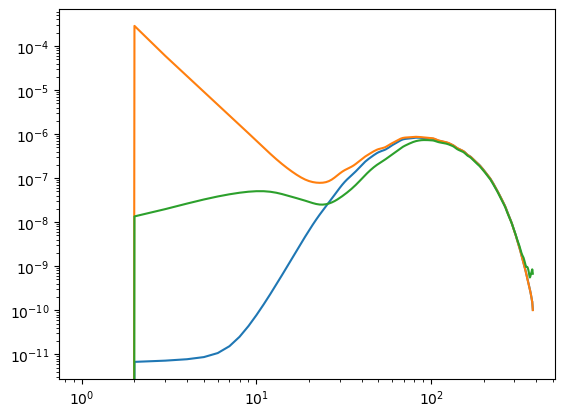

In [7]:
plt.plot(pcl)
plt.plot(pcl_KS)
plt.plot(pcl_pure)
plt.loglog()

In [23]:
reload(mylib)

# fl = pcl_KS / (bl**2 * mll_KS @ input_cls[2])
# fl[:2]=0
# fl = mylib.get_fl(pcl, bl, mll, fsky*w2, input_cls[2], niter=1)

# fl_pure = mylib.get_fl(cl, pcl_pure, bl, mll, fsky*w2, input_cls[2])
fl_pure = pcl_pure / bl**2 / fsky / w2 / input_cls[2]
fl_pure[:2] = 0

/tmp/ipykernel_46022/4112579594.py:8: RuntimeWarning: invalid value encountered in divide
  fl_pure = pcl_pure / bl**2 / fsky / w2 / input_cls[2]


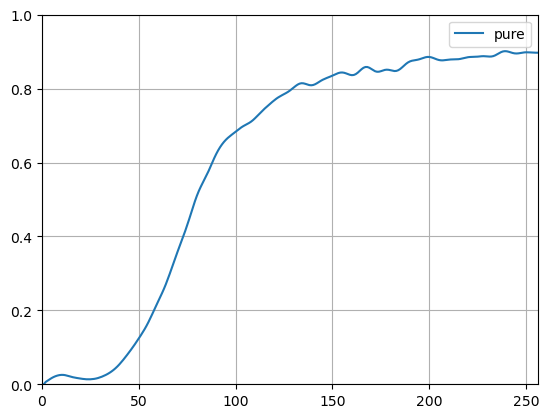

In [31]:
# plt.plot(fl)
plt.plot(fl_pure, label='pure')

plt.xlim([0, 2*nside])
plt.ylim([0,1])
plt.grid()
plt.legend()

In [25]:
# prefix='S4'

# nmc_noise = 256

# cl_noise = np.zeros((6, lmax+1))
# cl_noise_pure = np.zeros((6, lmax+1))
# nl = np.zeros((nmc_noise, len(ells)))

# for i in tqdm(range(nmc_noise)):
#     # np.random.seed(i+2000)
#     # noise = hp.synfast(noise_cls, nside, new=True)
#     # obs_noise_unapo = (R_unapo @ noise.flatten()).reshape(3, npix)
#     obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000}/filterbin_filtered_map.fits', field=None)
#     # obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000}/filterbin_filtered_map.fits', field=None)
#     obs_noise = mask_apo * obs_noise_unapo
#     cl_noise += hp.anafast(obs_noise)

#     f = nmt.NmtField(mask_apo, mask*obs_noise_unapo[1:], beam=bl*np.sqrt(fl))
#     nl[i] = nmt.compute_full_master(f, f, b)[3]
    
#     # obs_noise[1:] = (pi_b @ obs_noise[1:].flatten()).reshape(2, npix)
#     # cl_noise_pure += hp.anafast(obs_noise)

# cl_noise /= nmc_noise
# cl_noise_pol = np.array([cl_noise[1], cl_noise[4], cl_noise[4], cl_noise[2]])

# # cl_noise_pure /= nmc_noise
# # cl_noise_pure_pol = np.array([cl_noise_pure[1], cl_noise_pure[4], cl_noise_pure[4], cl_noise_pure[2]])

# mean_nl = np.mean(nl, axis=0)
# std_nl = np.std(nl, axis=0)

In [26]:
# plt.plot(cl_noise[2])
# plt.plot(cl_noise_pure[2], label='pure')
# # plt.loglog()
# plt.grid()
# plt.legend()
# plt.xlim([20, 2*nside])

In [27]:
# #roughly by eye

# planck_T_noise_props = [25, 50, -1.8]
# planck_P_noise_props = [50, 20, -1.4]
# planck_T = mylib.get_Nl(planck_T_noise_props, lmax)/bl**2
# planck_P = mylib.get_Nl(planck_P_noise_props, lmax)/bl**2
# planck_noise_cls = np.array([planck_T, planck_P, planck_P, np.zeros(lmax+1)])

# lb_T_noise_props = [1.8, 5, -1] 
# lb_P_noise_props = [2.16, 5, -1] 
# lb_T = mylib.get_Nl(lb_T_noise_props, lmax)/bl**2
# lb_P = mylib.get_Nl(lb_P_noise_props, lmax)/bl**2
# lb_noise_cls = np.array([lb_T, lb_P, lb_P, np.zeros(lmax+1)])

# # sat_pol_baseline = mylib.get_Nl([np.sqrt(2)*3.3, 50, -3], lmax)/bl**2
# # sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 25, -3], lmax)/bl**2
# sat_pol_optimal = mylib.get_Nl([np.sqrt(2)*2.1, 50, -3], lmax)/bl**2

# s4 = mylib.get_Nl([1, 50, -2], lmax)/bl**2

# plt.errorbar(ells, c2db*mean_nl, yerr=c2db*std_nl, fmt='.', label='Nl_bb')
# plt.plot(c2d*s4, label='s4')
# # plt.plot(c2d*sat_pol_baseline, label='sat pol baseline')
# plt.plot(c2d*sat_pol_optimal, label='sat pol optimal')

# # plt.plot(c2d*planck_T, label='planck T')
# plt.plot(c2d*planck_P, label='planck P')

# # plt.plot(c2d*lb_T, label='lb T')
# plt.plot(c2d*lb_P, label='lb P')

# # plt.plot(c2d*input_cls[1])

# plt.legend()
# plt.loglog()
# plt.grid()
# plt.xlim([40, 2*nside])

In [28]:
nmc = 100
cl_KS = np.empty((nmc, len(ells)))
cl_matpure = np.empty((nmc, len(ells)))
cl_restore_planck = np.empty((nmc, len(ells)))
cl_restore_lb = np.empty((nmc, len(ells)))
cl_restore_noiseless = np.empty((nmc, len(ells)))

for i in tqdm(range(nmc)):
    # signal 
    np.random.seed(i)
    # signal = hp.synfast(input_cls, nside, fwhm=fwhm, new=True)
    signal = hp.synfast(input_cls_noEE, nside, fwhm=fwhm, new=True)
    # signal = hp.synfast(input_cls_noBB, nside, fwhm=fwhm, new=True)
    obs_signal_unapo = (R_unapo @ signal.flatten()).reshape(3, npix) 

    # noise 
    # obs_noise_unapo = hp.read_map(f'{prefix}/out/{i+1000+nmc_noise}/filterbin_filtered_map.fits', field=None)

    #signal + noise
    obs_m_unapo = obs_signal_unapo #+ obs_noise_unapo
    
    #regular KS
    # f = nmt.NmtField(mask_apo, mask*obs_m_unapo[1:], beam=bl*np.sqrt(np.abs(fl)), purify_b=False)
    # cl_KS[i] = nmt.compute_full_master(f, f, b, cl_noise_pol)[3]
    # cl_KS[i] = nmt.compute_full_master(f, f, b)[3]
    
    #matrix pure
    obs_m_apo = mask_apo * obs_m_unapo #since purification was constructed to apply to apodized maps
    pure_QU = (pi_b @ obs_m_apo[1:].flatten()).reshape(2, npix)
    f = nmt.NmtField(mask_apo, mask*pure_QU, beam=bl*np.sqrt(fl_pure), masked_on_input=True)
    # cl_matpure[i] = nmt.compute_full_master(f, f, b, cl_noise_pure_pol)[3]
    cl_matpure[i] = nmt.compute_full_master(f, f, b)[3]

#     #planck restored
#     np.random.seed(i+2000)
#     planck_noise = hp.synfast(planck_noise_cls, nside, new=True)
#     E_map = mylib.wiener_filter(signal + planck_noise, input_cls, planck_noise_cls)
#     observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
#     restored_map = obs_m_unapo + E_map - observed_E_map
#     B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
#     f = nmt.NmtField(mask_apo, mask*[B_map], beam=bl*np.sqrt(fl))
#     cl_restore_planck[i] = nmt.compute_full_master(f, f, b, [cl_noise[2]])[0]
#     # cl_restore_planck[i] = nmt.compute_full_master(f, f, b)[0]

#     #lb restored
#     np.random.seed(i+3000)
#     lb_noise = hp.synfast(lb_noise_cls, nside, new=True)
#     E_map = mylib.wiener_filter(signal + lb_noise, input_cls, lb_noise_cls)
#     observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
#     restored_map = obs_m_unapo + E_map - observed_E_map
#     B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
#     f = nmt.NmtField(mask_apo, mask*[B_map], beam=bl*np.sqrt(fl))
#     cl_restore_lb[i] = nmt.compute_full_master(f, f, b, [cl_noise[2]])[0]
#     # cl_restore_lb[i] = nmt.compute_full_master(f, f, b)[0]

#     #restore_noiseless
#     E_map = mylib.remove_almB(signal)
#     observed_E_map = (R_unapo @ E_map.flatten()).reshape(3, npix)
#     restored_map = obs_m_unapo + E_map - observed_E_map
#     B_map = hp.alm2map(hp.map2alm(restored_map)[2], nside)
#     f = nmt.NmtField(mask_apo, mask*[B_map], beam=bl*np.sqrt(fl))
#     cl_restore_noiseless[i] = nmt.compute_full_master(f, f, b, [cl_noise[2]])[0]
#     # cl_restore_noiseless[i] = nmt.compute_full_master(f, f, b)[0]


# mean_KS = c2db * np.mean(cl_KS, axis=0)
# std_KS = c2db * np.std(cl_KS, axis=0)
      
mean_matpure = c2db * np.mean(cl_matpure, axis=0)
std_matpure = c2db * np.std(cl_matpure, axis=0)
      
# mean_restore_planck = c2db * np.mean(cl_restore_planck, axis=0)
# std_restore_planck = c2db * np.std(cl_restore_planck, axis=0)

# mean_restore_lb = c2db * np.mean(cl_restore_lb, axis=0)
# std_restore_lb = c2db * np.std(cl_restore_lb, axis=0)

# mean_restore_noiseless = c2db * np.mean(cl_restore_noiseless, axis=0)
# std_restore_noiseless = c2db * np.std(cl_restore_noiseless, axis=0)

100%|█████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


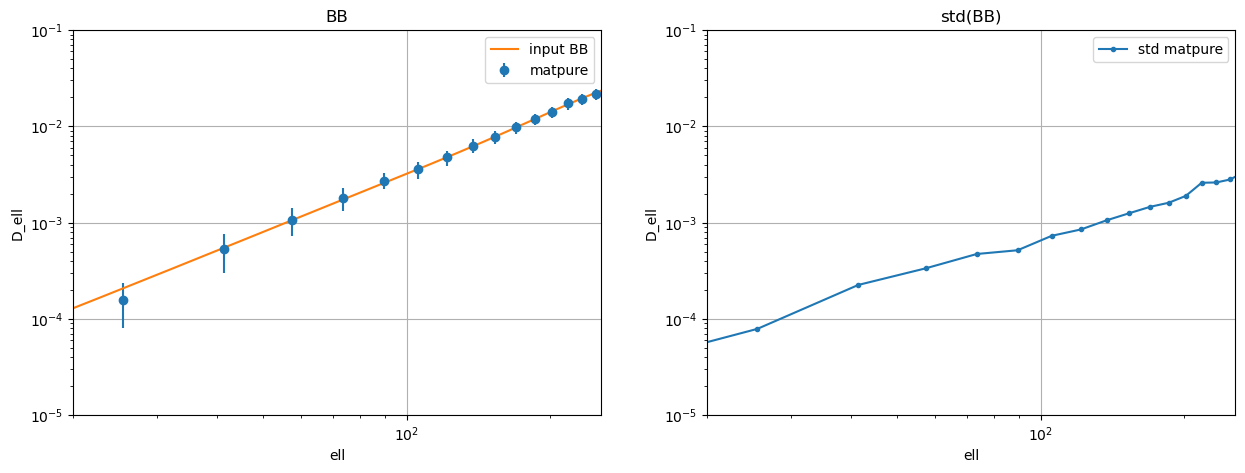

In [29]:
# w = nmt.NmtWorkspace()
# f = nmt.NmtField(mask_apo, np.empty((2, npix)), beam=bl*np.sqrt(fl))
# w.compute_coupling_matrix(f, f, b)
# bpw = w.get_bandpower_windows()[3, :, 3]

# nu_l = (2*l+1)*fsky*w2**2/w4*bin_size*fl
# knox = (bpw@input_cls[2] + mean_nl) * np.sqrt(2/(bpw@nu_l))
# # knox = (bpw@input_cls[2]) * np.sqrt(2/(bpw@nu_l))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# axes[0].errorbar(ells, mean_KS, yerr=std_KS, fmt='o', label='KS')
# axes[0].errorbar(ells, c2db*mean_nl, yerr=c2db*std_nl, fmt='.', label='Nl_bb')
# axes[0].errorbar(ells, mean_restore_planck, yerr=std_restore_planck, fmt='o', label='restore planck')
# axes[0].errorbar(ells, mean_restore_lb, yerr=std_restore_lb, fmt='o', label='restored lb')
axes[0].errorbar(ells, mean_matpure, yerr=std_matpure, fmt='o', label='matpure')
# axes[0].errorbar(ells, mean_restore_noiseless, yerr=std_restore_noiseless, fmt='o', label='restore noiseless')
axes[0].plot(c2d*input_cls[2], label='input BB')
# axes[0].plot(c2d*Nl_P_planck, label='Planck Nl_P', linestyle='dashed')
# axes[0].plot(c2d*Nl_P_lb, label='LB Nl_P', linestyle='dashed')

# axes[0].plot(c2d*cl_noise[2], label='residual noise', linestyle='dashed')
# axes[0].plot(c2d*cl_noise_pure[2], label='residual noise pure', linestyle='dashed')
axes[0].set_title('BB')
# axes[0].set_ylim([1e-5, 1e-1])

# axes[1].plot(ells, std_KS, marker='.',label='std KS')
# axes[1].plot(ells, std_restore_planck, marker='.',label='std restore planck')
# axes[1].plot(ells, std_restore_lb, marker='.',label='std restore lb')
axes[1].plot(ells, std_matpure, marker='.',label='std matpure')
# axes[1].plot(ells, std_restore_noiseless, marker='.',label='std restore noiseless')
# axes[1].plot(ells, c2db*knox, label='knox')
axes[1].set_title('std(BB)')
# axes[1].set_ylim([1e-4, 1e-2])

for ax in axes.flatten():
    ax.legend()
    ax.set_xlim([20, 2*nside])
    ax.set_ylim([1e-5, 1e-1])
    ax.loglog()
    ax.grid()
    ax.set_xlabel('ell')
    ax.set_ylabel('D_ell')

In [15]:
# cl_r1 = get_camb(0, 1, lmax) 
# cl_BB_r1 = bpw@cl_r1[2] 

In [16]:
# ell_min = 50
# ell_max = 2*nside
# inds = (ells >=ell_min) & (ells <= ell_max)

# sigma_r_KS = np.zeros(nmc)
# sigma_r_planck = np.zeros(nmc)
# sigma_r_lb = np.zeros(nmc)
# sigma_r_matpure = np.zeros(nmc)
# sigma_r_restore_noiseless = np.zeros(nmc)

# for i in range(nmc):
#     sigma_r_KS[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * (cl_BB_r1[inds] / cl_KS[i][inds])**2 )) 
#     sigma_r_planck[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * (cl_BB_r1[inds] / cl_restore_planck[i][inds])**2 )) 
#     sigma_r_lb[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * (cl_BB_r1[inds] / cl_restore_lb[i][inds])**2 ))     
#     sigma_r_matpure[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * (cl_BB_r1[inds] / cl_matpure[i][inds])**2 )) 
#     sigma_r_restore_noiseless[i] = 1/np.sqrt(fsky/2 * np.sum( (2*ells[inds]+1) * (cl_BB_r1[inds] / cl_restore_noiseless[i][inds])**2 )) 

In [35]:
# plt.figure(figsize=(8,5))
# plt.hist(sigma_r_KS, label='KS', alpha=0.75, edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_matpure, label='matpure', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_planck, label='planck', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_lb, label='lb', alpha=0.75,edgecolor='black', linewidth=0.5)
# plt.hist(sigma_r_restore_noiseless, label='restore noiseless', alpha=0.75,edgecolor='black', linewidth=0.5)

# plt.legend()
# plt.grid()
# plt.xlabel('sigma(r)')
# plt.ylabel('# MC')
# # plt.semilogx()

# print(np.median(sigma_r_KS), np.median(sigma_r_planck), np.median(sigma_r_lb), np.median(sigma_r_matpure), np.median(sigma_r_restore_noiseless))